# Advanced business analytics - Exploratory notebook

Import packages and data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from matplotlib import cm
from PIL import Image
import os
import PIL
import glob
tqdm.pandas()
df = pd.read_csv("Data/articles_data.csv")

In [21]:
df

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10432,10432,abc-news,ABC News,The Associated Press,Drop in US service sector activity raises econ...,"Get breaking national and world news, broadcas...",https://abcnews.go.com/Business/wireStory/drop...,https://s.abcnews.com/images/US/WireAP_eb147c9...,2019-10-03T16:30:16Z,Growth in the U.S. economys vast services sect...,0.0,0.0,0.0,0.0,0.0
10433,10433,reuters,Reuters,Sumeet Chatterjee,Banker defections pose challenge for Credit Su...,The announcement by Julius Baer this week that...,https://www.reuters.com/article/us-credit-suis...,https://s3.reutersmedia.net/resources/r/?m=02&...,2019-10-03T15:59:52Z,ZURICH/HONG KONG (Reuters) - The announcement ...,0.0,0.0,0.0,627.0,0.0
10434,10434,cnn,CNN,"Lauren M. Johnson, CNN","A 5-year-old cancer survivor donates 3,000 toy...",Weston Newswanger is just a normal 5-year-old ...,https://www.cnn.com/2019/10/03/us/five-year-ol...,https://cdn.cnn.com/cnnnext/dam/assets/1910021...,2019-10-03T11:20:06Z,NaN,0.0,4072.0,179.0,466.0,0.0
10435,10435,cbs-news,CBS News,CBS News,Fateful Connection,A detective is haunted by the case of two wome...,https://www.cbsnews.com/video/fateful-connecti...,https://cbsnews1.cbsistatic.com/hub/i/r/2019/1...,2019-10-03T16:40:03Z,NaN,0.0,0.0,0.0,0.0,0.0


### Basic exploration of the data

This data exploration will main revovle around the article data set, where each row represents an unique article. In the output below an overview of the columns and their data type can be seen. Most of the columns are rather self-explainatory. However, a few require further elaboration:
* "Content" - which only contains the first 250 characters in each article

* "top_article" - a binary column indicating if article was listed as a top article on publisher website

* "engagement_reaction_count" - Users reactions count for posts on Facebook involving article URL

* "engagement_comment_count" - Users comments count for posts on Facebook involving article URL

* "engagement_share_count" - Users shares count for posts on Facebook involving article URL

* "engagement_comment_plugin_count" - Users comments count for Facebook comment plugin on article website

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10437 non-null  int64  
 1   source_id                        10437 non-null  object 
 2   source_name                      10437 non-null  object 
 3   author                           9417 non-null   object 
 4   title                            10435 non-null  object 
 5   description                      10413 non-null  object 
 6   url                              10436 non-null  object 
 7   url_to_image                     9781 non-null   object 
 8   published_at                     10436 non-null  object 
 9   content                          9145 non-null   object 
 10  top_article                      10435 non-null  float64
 11  engagement_reaction_count        10319 non-null  float64
 12  engagement_comment

A further look into the data shows that there a missing values in most of the columns, however we have 10000 unique articles, so for the sake of having clean data

In [4]:
NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)
NA.style.background_gradient(cmap="summer", subset=['NA Count'])



,NA Count,NA Percent
content,1292,12.38%
author,1020,9.77%
url_to_image,656,6.29%
engagement_reaction_count,118,1.13%
engagement_comment_count,118,1.13%
engagement_share_count,118,1.13%
engagement_comment_plugin_count,118,1.13%
description,24,0.23%
title,2,0.02%
top_article,2,0.02%


In [5]:
df = df.dropna(subset = [ 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'published_at',
       'top_article', 'engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count', 'content'])

In [6]:
df.published_at = pd.to_datetime(df.published_at)

df['Day_Of_Week'] = df.published_at.apply(lambda x: x.dayofweek)
df['Month'] = df.published_at.apply(lambda x: x.month)
df['Year'] = df.published_at.apply(lambda x: x.year)


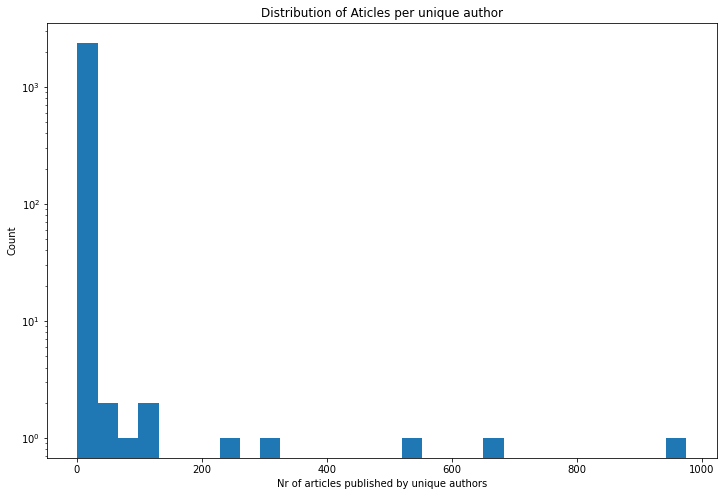

In [7]:
df.author.value_counts().plot(kind="hist",logy=True,
                              title=("Distribution of Aticles per unique author"),
                              figsize=(12,8),
                              bins=30);
plt.ylabel("Count")
plt.xlabel("Nr of articles published by unique authors")
plt.show()

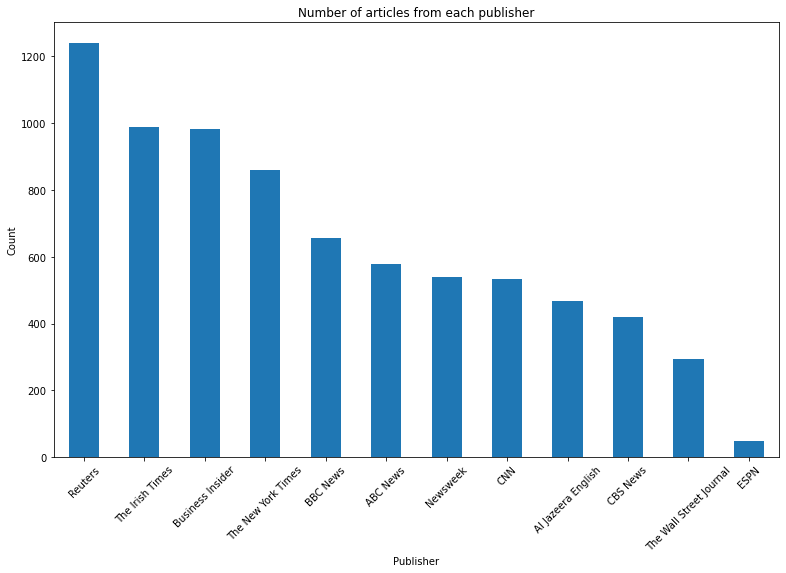

In [7]:
df.source_name.value_counts().plot(kind="bar",
                                   ylabel="Count",
                                   xlabel="Publisher",
                                   title="Number of articles from each publisher",
                                   figsize=(13,8),
                                   rot=45);

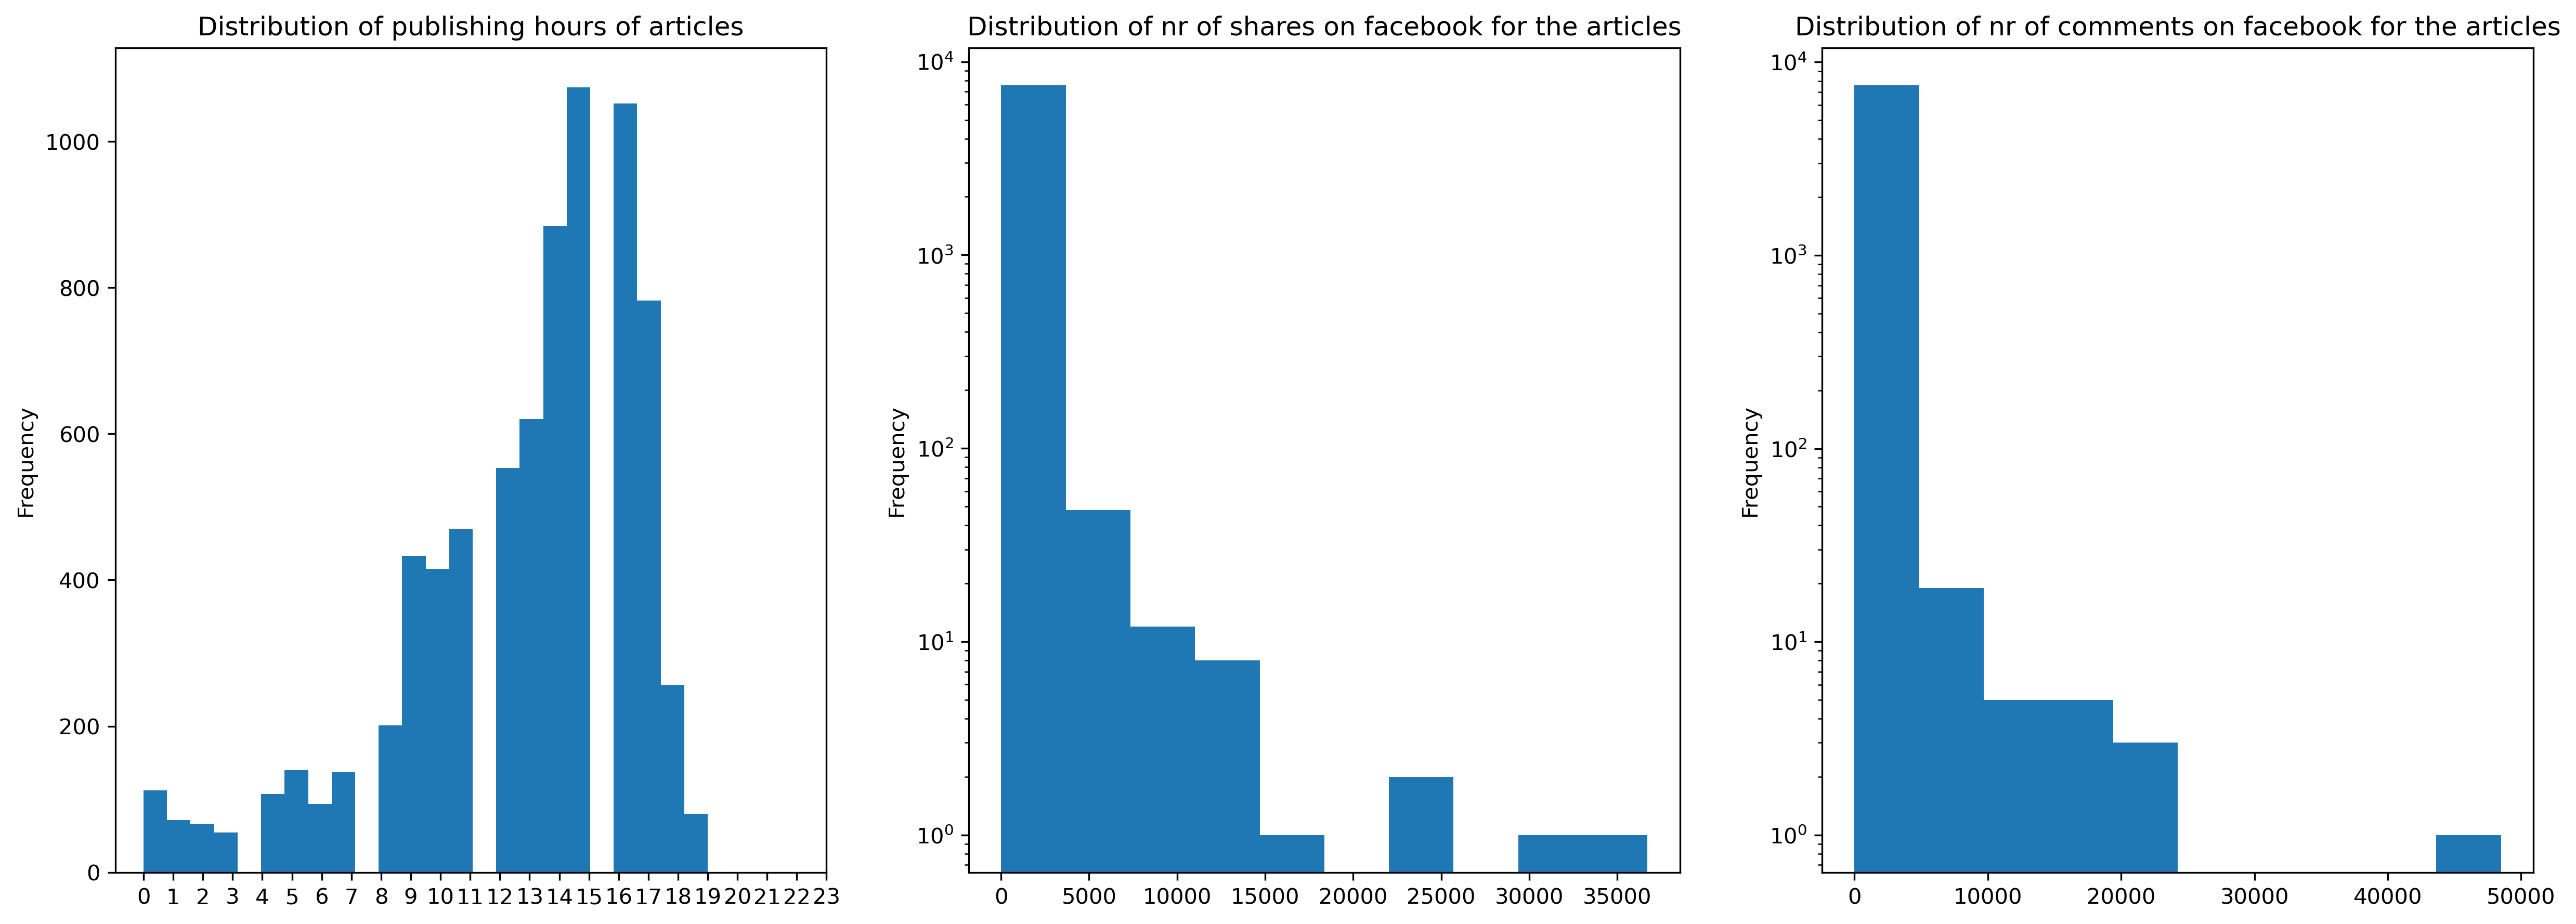

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(50,15),dpi=300)
pd.to_datetime(df.published_at).dt.hour.plot(kind="hist",
                                             xticks=np.arange(0,24,1),
                                             bins=24,
                                             xlabel="hour published",
                                             ylabel="Count",
                                             title="Distribution of publishing hours of articles",
                                             figsize=(15,7),
                                             ax=axes[0]);
df.engagement_share_count.plot(kind="hist",
                               logy=True,
                               xlabel="Nr of shares on facebook",
                               ylabel="Count",
                               title="Distribution of nr of shares on facebook for the articles",
                               figsize=(15,7),
                               ax=axes[1]);
df.engagement_comment_count.plot(kind="hist",
                               logy=True,
                               xlabel="Nr of comments on facebook",
                               ylabel="Count",
                               title="Distribution of nr of comments on facebook for the articles",
                               figsize=(20,7),
                               ax=axes[2]);


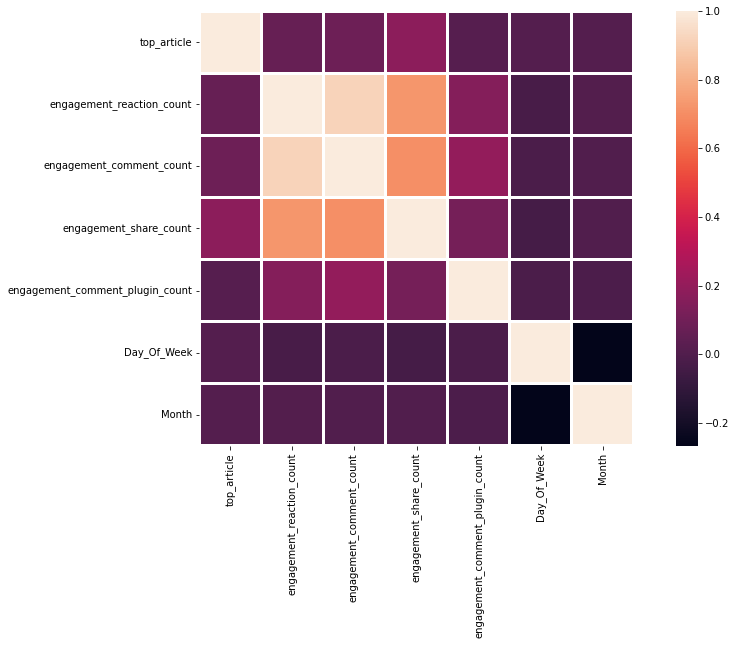

In [66]:
corr=df.drop(columns=["Year"]).corr()
plt.figure(figsize=(15,8))
ax1 = sns.heatmap(corr, linewidths=2, square=True, cmap='rocket')
plt.show()

In [39]:
from os import listdir
from os.path import isfile, join
mypath="/Users/martinillum/Desktop/Desktop_mac_air/Kandidat/Advanced_business_analytics/Final_project/ABA_2022/Data/images"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
sorted_list = [x.split(".")[0] for x in onlyfiles]
sorted_list = sorted(sorted_list)[1:]
sorted_list = sorted([int(x) for x in sorted_list])
sorted_list = [str(x)+".png" for x in sorted_list]

In [31]:
df.engagement_reaction_count

0          0.0
1          6.0
3          0.0
6          0.0
7          0.0
         ...  
10428    405.0
10429      0.0
10431      2.0
10432      0.0
10433      0.0
Name: engagement_reaction_count, Length: 7604, dtype: float64

/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/martinillum/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

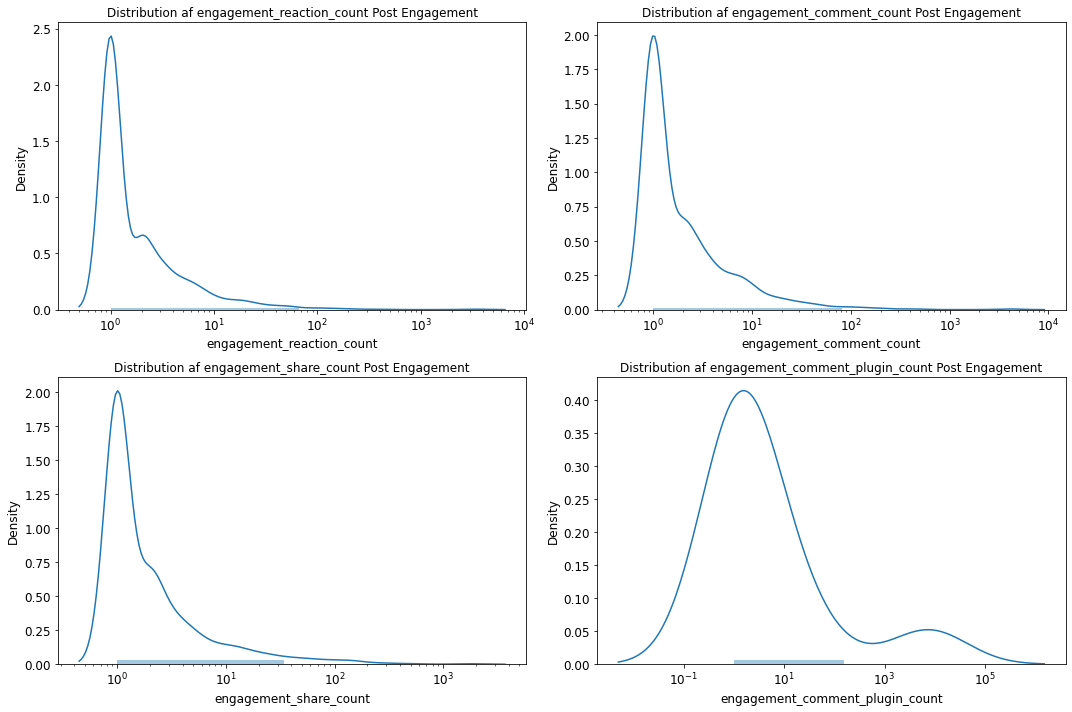

In [76]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
channels=['engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count']
k=0
for j in range(len(ax)):
    for i in range(len(ax[j])):
        ax[j][i].tick_params(labelsize=12)
        ax[j][i].set_xlabel('label', fontsize=12, position=(.5,20))
        ax[j][i].set_ylabel('Density', fontsize=12)
        ax[j][i].set_title(f'Distribution af {channels[k]} Post Engagement', size=12)
        ax[j][i].set(xscale="log")
        ax[j][i] = sns.distplot(df[channels[k]].value_counts(), ax=ax[j][i])
        k+=1

fig.tight_layout()
#plt.savefig("DistKanal.png")

fig.show()

## Scraping full article text

In [1]:
df_scrape = df.dropna(subset = ['source_id', 'source_name', 'author', 'title',
       'description', 'url', 'published_at',
       'top_article', 'engagement_reaction_count', 'engagement_comment_count',
       'engagement_share_count', 'engagement_comment_plugin_count'])

def url_scraper(url):
    try:
        html = requests.get(url).content
        soup = BeautifulSoup(html, features="html.parser")

        # kill all script and style elements
        for script in soup(["script", "style"]):
            script.extract()    # rip it out




        # get text
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)
    except:
        text = "NA"
        print(url)
    return text

#Very slow function
# Limited by ca. 1.5 call pr sec 
df_scrape["contentX"] = df_scrape['url'].progress_apply(lambda x: url_scraper(x))

NameError: name 'df' is not defined

In [19]:
df.content[0]

'WASHINGTON (Reuters) - The National Transportation Safety Board said Tuesday a Tesla Model S was in Autopilot mode when it struck a fire truck in Culver City, California one of a series of crashes the board is investigating involving Tesla’s driver assistance… [+478 chars]'

# Image_Scrape

In [ ]:
import re
front="/images/"
front2="/image/"
end="-"
Front_url="https://i.insider.com/"

new_urls=[]

for i in range(len(df)):
    if df.source_id.iloc[i]=="business-insider":
        try:
                if df.iloc[i].url_to_image[0:11]=="https://amp":
                    id_name=re.search(f'{front}(.*)', df.iloc[i].url_to_image.split("-")[0]).group(1)
                    full_url = Front_url+id_name
                    new_urls.append(full_url)

                else:
                    id_name=re.search(f'{front2}(.*)', df.iloc[i].url_to_image.split("-")[0]).group(1)
                    full_url = Front_url+id_name
                    new_urls.append(full_url)
        except:
            new_urls.append(df.iloc[i].url_to_image)
    else: new_urls.append(df.iloc[i].url_to_image)

In [ ]:
#new_urls = [x.replace("https://","") for x in new_urls]
#new_urls = [x.replace("//","") for x in new_urls]
df['url_to_image_real']=new_urls

In [ ]:
urls=[x for x in df.url_to_image_real]
index=[x for x in df.index]

In [ ]:
import time
def im_scrape(urls,filename):
    call = requests.get(urls)
    if str(call)=="<Response [200]>":
        img_data = call.content
        with open(f'images/{filename}.png', 'wb') as handler:
             handler.write(img_data)
        #time.sleep(2) 
        image=Image.open(f"images/{filename}.png")
        resized_image = image.resize((128,128))
        resized_image.save(f'images/{filename}.png')
        
    else:
        print(urls)

In [ ]:
len(urls)
index.index(6564)

4803

In [ ]:
for i in range(index.index(6565),len(urls)):
    try:
        im_scrape(urls[i],index[i])
    except:
        print(urls[i])

https://www.irishtimes.com/image-creator/?id=1.4036177&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4036386&origw=1440
https://s.abcnews.com/images/Health/trump-autism-bill-ht-jt-191002_hpMain_16x9_992.jpg
https://a1.espncdn.com/combiner/i?img=%2Fmedia%2Fmotion%2F2019%2F1002%2Fdm_191002_gardner_minshew%2Fdm_191002_gardner_minshew.jpg
https://www.irishtimes.com/image-creator/?id=1.4037642&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4038725&origw=1058
https://www.irishtimes.com/image-creator/?id=1.4038841&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4038955&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4039311&origw=1440
https://www.irishtimes.com/image-creator/?id=1.4039320&origw=1440


Removing rows that does not have an image scraped

In [7]:
from os import listdir
from os.path import isfile, join
mypath="/Users/martinillum/Desktop/Desktop_mac_air/Kandidat/Advanced_business_analytics/Final_project/ABA_2022/Data/images"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
sorted_list = [x.split(".")[0] for x in onlyfiles]
sorted_list = sorted(sorted_list)[1:]
sorted_list_number = sorted([int(x) for x in sorted_list])
sorted_list = [str(x)+".png" for x in sorted_list_number]

In [9]:
df = df.loc[sorted_list_number]

In [18]:
df=df.rename(columns = {df.columns[0]:'Image_path'})

In [19]:
df.to_csv("Data/Final_data_cleaing.csv")

In [129]:
df.co,

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,Day_Of_Week,Month,Year
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03 16:22:20+00:00,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0,1,9,2019
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03 10:32:28+00:00,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0,1,9,2019
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03 17:25:39+00:00,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0,1,9,2019
6,6,reuters,Reuters,Reuters Editorial,EU wants to see if lawmakers will block Brexit...,The European Union is waiting to see if Britis...,https://www.reuters.com/article/us-britain-eu-...,https://s2.reutersmedia.net/resources/r/?m=02&...,2019-09-03 16:25:41+00:00,LONDON (Reuters) - The European Union is waiti...,0.0,0.0,0.0,817.0,0.0,1,9,2019
7,7,reuters,Reuters,Reuters Editorial,European third quarter profit outlook improves...,Earnings and revenue expectations for European...,https://www.reuters.com/article/us-europe-stoc...,https://s2.reutersmedia.net/resources/r/?m=02&...,2019-09-03 16:53:48+00:00,LONDON (Reuters) - Earnings and revenue expect...,0.0,0.0,0.0,0.0,0.0,1,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10428,10428,abc-news,ABC News,Melanie Curtsinger,Disney Cruise Line Begins Sailings from New Yo...,"Just last week, the Disney Magic arrived to Ne...",https://disneyparks.disney.go.com/blog/2019/10...,https://cdn1.parksmedia.wdprapps.disney.com/me...,2019-10-03 17:00:59+00:00,"Just last week, the Disney Magic arrived to Ne...",0.0,405.0,71.0,62.0,0.0,3,10,2019
10429,10429,cbs-news,CBS News,CBS News,Picturing male breast cancer,Photographer David Jay portrays breast cancer ...,https://www.cbsnews.com/pictures/picturing-mal...,https://cbsnews3.cbsistatic.com/hub/i/r/2014/0...,2019-10-03 14:53:44+00:00,For his latest installation of the SCAR Projec...,0.0,0.0,0.0,0.0,0.0,3,10,2019
10431,10431,business-insider,Business Insider,Akin Oyedele,GOLDMAN SACHS: Buy these 11 stocks poised to s...,Goldman Sachs has updated its quarterly list o...,https://www.businessinsider.com/stock-picks-fr...,https://image.businessinsider.com/5d9617d6d598...,2019-10-03 17:39:25+00:00,There are numerous bargains waiting to be pick...,0.0,2.0,0.0,1.0,0.0,3,10,2019
10432,10432,abc-news,ABC News,The Associated Press,Drop in US service sector activity raises econ...,"Get breaking national and world news, broadcas...",https://abcnews.go.com/Business/wireStory/drop...,https://s.abcnews.com/images/US/WireAP_eb147c9...,2019-10-03 16:30:16+00:00,Growth in the U.S. economys vast services sect...,0.0,0.0,0.0,0.0,0.0,3,10,2019
